<a href="https://colab.research.google.com/github/saraex6/Transfer-Learning-and-fine-tuning---VGG16-ResNet-50-Inception-V3-/blob/main/VGG_16_Using_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#Mounting Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
import os
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

# Define image transformations

In [21]:
BATCH_SIZE = 64
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) #preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) #preprocessing


# Downloading the Dataset

In [22]:
train_data_dir = '/content/gdrive/MyDrive/Train'
test_data_dir = '/content/gdrive/MyDrive/Test'


traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)


Found 1022 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 212 images belonging to 2 classes.



Define create model function for which we determine the training approach 



In [23]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [24]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE


# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)


In [25]:
pip install git+git://github.com/stared/livelossplot.git

  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-n2cw_2ii
  Running command git clone -q git://github.com/stared/livelossplot.git /tmp/pip-req-build-n2cw_2ii


In [26]:
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot.inputs.tf_keras import PlotLossesCallback

from livelossplot import PlotLossesKeras

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping: monitors the performance of the model and stopping the training process prevents overtraining
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


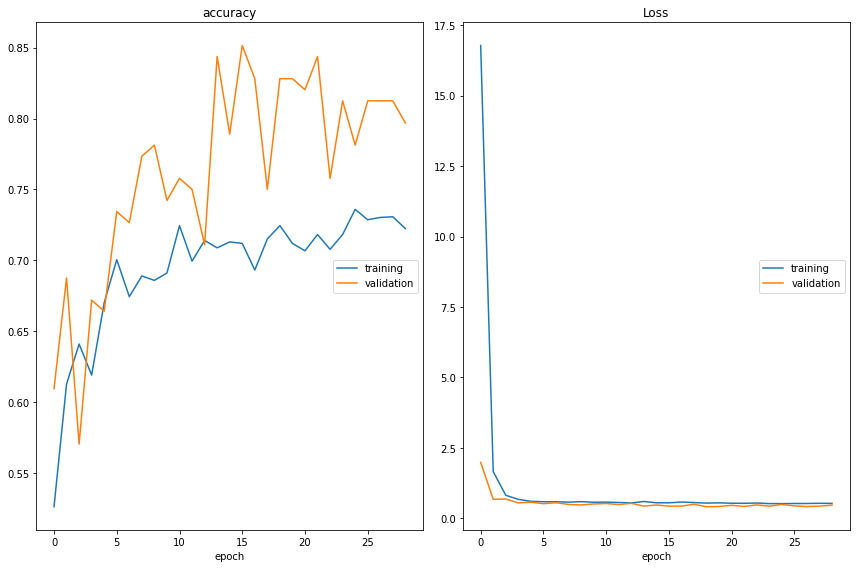

accuracy
	training         	 (min:    0.526, max:    0.736, cur:    0.722)
	validation       	 (min:    0.570, max:    0.852, cur:    0.797)
Loss
	training         	 (min:    0.525, max:   16.781, cur:    0.532)
	validation       	 (min:    0.414, max:    1.989, cur:    0.470)
15/15 [==============================] - 694s 46s/step - loss: 0.5325 - accuracy: 0.7223 - val_loss: 0.4696 - val_accuracy: 0.7969
CPU times: user 10h 54min 47s, sys: 5min 11s, total: 10h 59min 58s
Wall time: 5h 53min 44s


In [27]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            validation_data=validgen,
                            epochs=50,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[early_stop, plot_loss_1],
                            verbose=1)


In [28]:
# Generate predictions
#vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)


In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

vgg_f1 = f1_score(true_classes, vgg_pred_classes)
print("VGG16 Model f1_score without Fine-Tuning: {:.2f}%".format(vgg_f1 * 100))

vgg_precision_score = precision_score(true_classes, vgg_pred_classes)
print("VGG16 Model vgg_precision_score without Fine-Tuning: {:.2f}%".format(vgg_precision_score * 100))

vgg_recall_score = recall_score(true_classes, vgg_pred_classes)
print("VGG16 Model vgg_recall_score without Fine-Tuning: {:.2f}%".format(vgg_recall_score * 100))

vgg_log_loss = log_loss(true_classes, vgg_pred_classes)
print("VGG16 Model log_loss without Fine-Tuning: {:.2f}%".format(vgg_log_loss ))



VGG16 Model Accuracy without Fine-Tuning: 75.94%
VGG16 Model f1_score without Fine-Tuning: 77.13%
VGG16 Model vgg_precision_score without Fine-Tuning: 73.50%
VGG16 Model vgg_recall_score without Fine-Tuning: 81.13%
VGG16 Model log_loss without Fine-Tuning: 8.31%


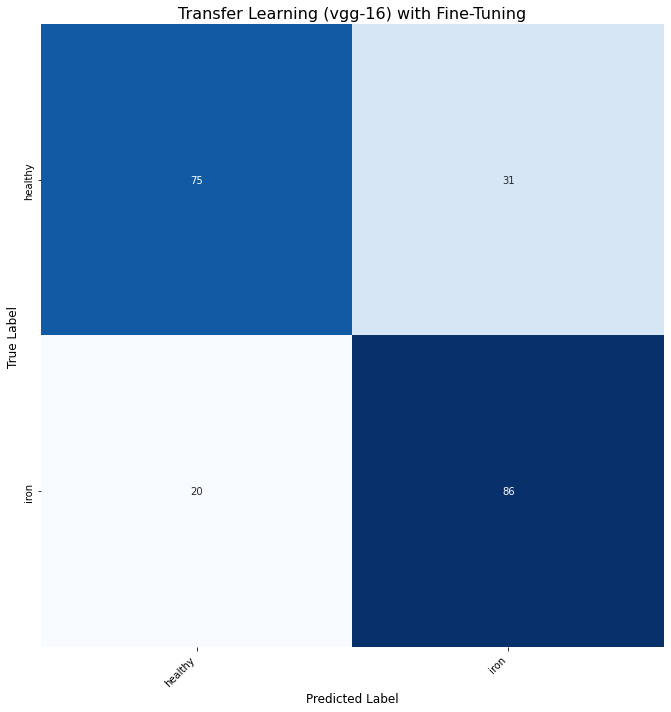

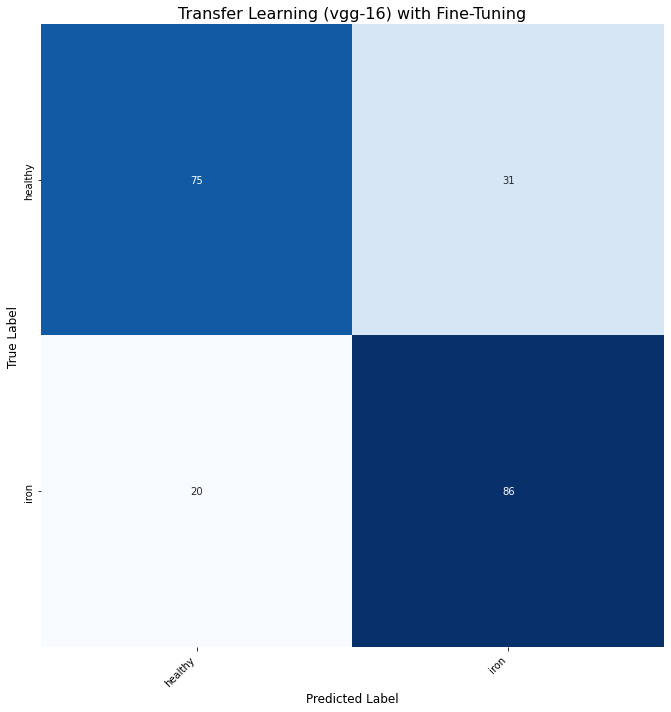

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

# Get the names of the classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax2) = plt.subplots(figsize=(20, 10))

plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (vgg-16) with Fine-Tuning")    

fig.tight_layout()

plt.show()
